In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
from torch.nn import CrossEntropyLoss
import torch.optim as optim
from torch.optim import SGD
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts
from torchvision import datasets
from torch.utils.data import DataLoader

from torchvision import models
from torchvision.transforms import Compose, Resize, CenterCrop, RandomCrop, RandomHorizontalFlip, RandomVerticalFlip, Normalize, ToTensor

from fl_g13.config import RAW_DATA_DIR
from fl_g13.modeling import train, eval, save, load, backup, load_loss_and_accuracies, save_loss_and_accuracy
from fl_g13.dataset import train_test_split

from fl_g13.architectures import BaseDino
from fl_g13.editing import SparseSGDM


2025-05-01 16:06:42.172 | INFO     | fl_g13.config:<module>:11 - PROJ_ROOT path is: /home/massimiliano/Projects/fl-g13


In [3]:
# Define preprocessing pipeline
train_transform = Compose([
    Resize(256), # CIFRA100 is originally 32x32
    RandomCrop(224), # But Dino works on 224x224
    RandomHorizontalFlip(),
    ToTensor(),
    #Normalize(mean=[0.5071, 0.4866, 0.4409], std=[0.2673, 0.2564, 0.2762]), # CIFRAR100 Train stats
    Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]) # Use ImageNet stats
])

eval_transform = Compose([
    Resize(256), # CIFRA100 is originally 32x32
    CenterCrop(224), # But Dino works on 224x224
    ToTensor(),
    #Normalize(mean=[0.5071, 0.4866, 0.4409], std=[0.2673, 0.2564, 0.2762]), # CIFRAR100 Train stats
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # Use ImageNet stats
])

cifar100_train = datasets.CIFAR100(root=RAW_DATA_DIR, train=True, download=True, transform=train_transform)
cifar100_test = datasets.CIFAR100(root=RAW_DATA_DIR, train=False, download=True, transform=eval_transform)

train_dataset, val_dataset = train_test_split(cifar100_train, 0.8, random_state=None)
test_dataset = cifar100_test

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 40000
Validation dataset size: 10000
Test dataset size: 10000


In [ ]:
# Move to CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Settings
CHECKPOINT_DIR = "/home/massimiliano/Projects/fl-g13/checkpoints"
name = "abra"
start_epoch=1
num_epochs=80
save_every=5
backup_every=20

# Model Hyper-parameters
head_layers=3
head_hidden_size=512
dropout_rate=0.0
unfreeze_blocks=5

# Training Hyper-parameters
batch_size=128
lr=1e-3
T_0=8
T_mult=2
eta_min=1e-5

# Dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Model
model = BaseDino(
    head_layers=head_layers, 
    head_hidden_size=head_hidden_size, 
    dropout_rate=dropout_rate, 
    unfreeze_blocks=unfreeze_blocks
    )
model.to(device)

# Optimizer, scheduler, and loss function
mask = [torch.ones_like(p, device=p.device) for p in model.parameters()] # Must be done AFTER the model is moved to CUDA
optimizer = SparseSGDM(
    model.parameters(), 
    mask=mask, 
    lr=lr
    )
scheduler = CosineAnnealingWarmRestarts(
    optimizer, 
    T_0=T_0, 
    T_mult=T_mult, 
    eta_min=eta_min
    )
criterion = CrossEntropyLoss()

all_training_losses=[]       # Pre-allocated list for training losses
all_validation_losses=[]       # Pre-allocated list for validation losses
all_training_accuracies=[]    # Pre-allocated list for training accuracies
all_validation_accuracies=[]    # Pre-allocated list for validation accuracies

# # Model loading (uncomment to properly overwrite)
# loading_epoch = 20
# model, start_epoch = load(
#     f"{CHECKPOINT_DIR}/BaseDino/{name}_BaseDino_epoch_{loading_epoch}.pth",
#     model_class=BaseDino,
#     device=device,
#     optimizer=optimizer,
#     scheduler=scheduler,
#     verbose=True
# )
# model.to(device)
# loaded_metrics = load_loss_and_accuracies(path=f"{CHECKPOINT_DIR}/BaseDino/{name}_BaseDino_epoch_{loading_epoch}.loss_acc.json")

# # Preallocated lists: if the training interrupts, it will still save their values (uncomment to properly load and overwrite)
# all_training_losses=loaded_metrics["train_loss"]       # Pre-allocated list for training losses
# all_validation_losses=loaded_metrics["val_loss"]       # Pre-allocated list for validation losses
# all_training_accuracies=loaded_metrics["train_acc"]    # Pre-allocated list for training accuracies
# all_validation_accuracies=loaded_metrics["val_acc"]    # Pre-allocated list for validation accuracies

print(f"\nModel: {model}")

Using device: cuda


Using cache found in /home/massimiliano/.cache/torch/hub/facebookresearch_dino_main



Model: BaseDino(
  (backbone): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=384, out_features=1152, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=384, out_features=384, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (drop_path): Identity()
        (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=384, out_features=1536, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=1536, out_features=384, bias=True)
          (drop): Dropout(p=0.0, inplace=False)
        )
      )
    )
    (norm):

In [5]:
# Get one batch of data from the test dataloader
data_iter = iter(test_dataloader)
images, labels = next(data_iter)

# Move the data to the same device as the model
images = images.to(device)

# Perform prediction
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

# Print the first prediction and its corresponding label
print(f"Predicted class: {predicted[0].item()}, True class: {labels[0].item()}")
print(f"Outputs shape: {outputs.shape}")

Predicted class: 53, True class: 49
Outputs shape: torch.Size([128, 100])


In [6]:
try:
    _, _, _, _ = train(
        checkpoint_dir=CHECKPOINT_DIR,
        name=name,
        start_epoch=start_epoch,
        num_epochs=num_epochs,
        save_every=save_every,
        backup_every=backup_every,
        train_dataloader=train_dataloader,
        val_dataloader=val_dataloader,
        model=model,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        verbose=1,
        all_training_losses=all_training_losses,
        all_validation_losses=all_validation_losses,
        all_training_accuracies=all_training_accuracies,
        all_validation_accuracies=all_validation_accuracies,
    )

except KeyboardInterrupt:
    print("Training interrupted manually.")

except Exception as e:
    print(f"Training stopped due to error: {e}")

Prefix/name for the model was provided: abra



Training progress:   0%|          | 0/313 [00:00<?, ?batch/s]

Training progress: 100%|██████████| 313/313 [02:01<00:00,  2.58batch/s]


🚀 Epoch 1/80 (1.25%) Completed
	📊 Training Loss: 2.7695
	✅ Training Accuracy: 35.44%
	⏳ Elapsed Time: 121.14s | ETA: 9570.24s
	🕒 Completed At: 16:08


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.08batch/s]


🔍 Validation Results:
	📉 Validation Loss: 1.5949
	🎯 Validation Accuracy: 56.35%



Training progress: 100%|██████████| 313/313 [02:01<00:00,  2.57batch/s]


🚀 Epoch 2/80 (2.50%) Completed
	📊 Training Loss: 1.1318
	✅ Training Accuracy: 68.34%
	⏳ Elapsed Time: 121.60s | ETA: 9485.01s
	🕒 Completed At: 16:11


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.05batch/s]


🔍 Validation Results:
	📉 Validation Loss: 1.1406
	🎯 Validation Accuracy: 67.74%



Training progress: 100%|██████████| 313/313 [01:59<00:00,  2.62batch/s]


🚀 Epoch 3/80 (3.75%) Completed
	📊 Training Loss: 0.7701
	✅ Training Accuracy: 77.84%
	⏳ Elapsed Time: 119.43s | ETA: 9196.11s
	🕒 Completed At: 16:13


Eval progress: 100%|██████████| 79/79 [00:18<00:00,  4.18batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.9161
	🎯 Validation Accuracy: 73.54%



Training progress: 100%|██████████| 313/313 [01:59<00:00,  2.62batch/s]


🚀 Epoch 4/80 (5.00%) Completed
	📊 Training Loss: 0.5834
	✅ Training Accuracy: 82.85%
	⏳ Elapsed Time: 119.52s | ETA: 9083.17s
	🕒 Completed At: 16:15


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.07batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.8172
	🎯 Validation Accuracy: 75.88%



Training progress: 100%|██████████| 313/313 [02:02<00:00,  2.56batch/s]


🚀 Epoch 5/80 (6.25%) Completed
	📊 Training Loss: 0.4631
	✅ Training Accuracy: 86.26%
	⏳ Elapsed Time: 122.29s | ETA: 9171.47s
	🕒 Completed At: 16:18


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  3.95batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.7628
	🎯 Validation Accuracy: 77.53%

💾 Saved checkpoint at: /home/massimiliano/Projects/fl-g13/checkpoints/BaseDino/abra_BaseDino_epoch_5.pth
💾 Saved losses and accuracies (training and validation) at: /home/massimiliano/Projects/fl-g13/checkpoints/BaseDino/abra_BaseDino_epoch_5.loss_acc.json



Training progress: 100%|██████████| 313/313 [02:01<00:00,  2.58batch/s]


🚀 Epoch 6/80 (7.50%) Completed
	📊 Training Loss: 0.3768
	✅ Training Accuracy: 89.32%
	⏳ Elapsed Time: 121.29s | ETA: 8975.67s
	🕒 Completed At: 16:20


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.03batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.7238
	🎯 Validation Accuracy: 78.80%



Training progress: 100%|██████████| 313/313 [01:59<00:00,  2.61batch/s]


🚀 Epoch 7/80 (8.75%) Completed
	📊 Training Loss: 0.3252
	✅ Training Accuracy: 90.99%
	⏳ Elapsed Time: 119.88s | ETA: 8751.57s
	🕒 Completed At: 16:22


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  3.97batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.7138
	🎯 Validation Accuracy: 79.15%



Training progress: 100%|██████████| 313/313 [01:59<00:00,  2.61batch/s]


🚀 Epoch 8/80 (10.00%) Completed
	📊 Training Loss: 0.2993
	✅ Training Accuracy: 91.74%
	⏳ Elapsed Time: 119.86s | ETA: 8629.97s
	🕒 Completed At: 16:25


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.04batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.7095
	🎯 Validation Accuracy: 79.23%



Training progress: 100%|██████████| 313/313 [02:02<00:00,  2.56batch/s]


🚀 Epoch 9/80 (11.25%) Completed
	📊 Training Loss: 0.4067
	✅ Training Accuracy: 87.70%
	⏳ Elapsed Time: 122.16s | ETA: 8673.31s
	🕒 Completed At: 16:27


Eval progress: 100%|██████████| 79/79 [00:20<00:00,  3.87batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.7835
	🎯 Validation Accuracy: 77.32%



Training progress: 100%|██████████| 313/313 [02:01<00:00,  2.58batch/s]


🚀 Epoch 10/80 (12.50%) Completed
	📊 Training Loss: 0.3187
	✅ Training Accuracy: 90.58%
	⏳ Elapsed Time: 121.37s | ETA: 8495.70s
	🕒 Completed At: 16:29


Eval progress: 100%|██████████| 79/79 [00:20<00:00,  3.93batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.7652
	🎯 Validation Accuracy: 78.03%

💾 Saved checkpoint at: /home/massimiliano/Projects/fl-g13/checkpoints/BaseDino/abra_BaseDino_epoch_10.pth
💾 Saved losses and accuracies (training and validation) at: /home/massimiliano/Projects/fl-g13/checkpoints/BaseDino/abra_BaseDino_epoch_10.loss_acc.json



Training progress: 100%|██████████| 313/313 [02:00<00:00,  2.59batch/s]


🚀 Epoch 11/80 (13.75%) Completed
	📊 Training Loss: 0.2443
	✅ Training Accuracy: 93.00%
	⏳ Elapsed Time: 120.89s | ETA: 8341.75s
	🕒 Completed At: 16:32


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.09batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.7229
	🎯 Validation Accuracy: 79.06%



Training progress: 100%|██████████| 313/313 [02:01<00:00,  2.58batch/s]


🚀 Epoch 12/80 (15.00%) Completed
	📊 Training Loss: 0.1892
	✅ Training Accuracy: 94.68%
	⏳ Elapsed Time: 121.26s | ETA: 8245.52s
	🕒 Completed At: 16:34


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  3.96batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.7180
	🎯 Validation Accuracy: 79.59%



Training progress: 100%|██████████| 313/313 [01:59<00:00,  2.62batch/s]


🚀 Epoch 13/80 (16.25%) Completed
	📊 Training Loss: 0.1449
	✅ Training Accuracy: 96.33%
	⏳ Elapsed Time: 119.32s | ETA: 7994.53s
	🕒 Completed At: 16:36


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.03batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.7225
	🎯 Validation Accuracy: 80.03%



Training progress: 100%|██████████| 313/313 [02:02<00:00,  2.56batch/s]


🚀 Epoch 14/80 (17.50%) Completed
	📊 Training Loss: 0.1124
	✅ Training Accuracy: 97.45%
	⏳ Elapsed Time: 122.23s | ETA: 8067.43s
	🕒 Completed At: 16:39


Eval progress: 100%|██████████| 79/79 [00:22<00:00,  3.46batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.7158
	🎯 Validation Accuracy: 80.05%



Training progress: 100%|██████████| 313/313 [02:00<00:00,  2.59batch/s]


🚀 Epoch 15/80 (18.75%) Completed
	📊 Training Loss: 0.0898
	✅ Training Accuracy: 98.13%
	⏳ Elapsed Time: 120.95s | ETA: 7861.53s
	🕒 Completed At: 16:41


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.04batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.7086
	🎯 Validation Accuracy: 80.45%

💾 Saved checkpoint at: /home/massimiliano/Projects/fl-g13/checkpoints/BaseDino/abra_BaseDino_epoch_15.pth
💾 Saved losses and accuracies (training and validation) at: /home/massimiliano/Projects/fl-g13/checkpoints/BaseDino/abra_BaseDino_epoch_15.loss_acc.json



Training progress: 100%|██████████| 313/313 [01:59<00:00,  2.61batch/s]


🚀 Epoch 16/80 (20.00%) Completed
	📊 Training Loss: 0.0758
	✅ Training Accuracy: 98.50%
	⏳ Elapsed Time: 119.71s | ETA: 7661.54s
	🕒 Completed At: 16:43


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.06batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.7159
	🎯 Validation Accuracy: 80.94%



Training progress: 100%|██████████| 313/313 [02:00<00:00,  2.60batch/s]


🚀 Epoch 17/80 (21.25%) Completed
	📊 Training Loss: 0.0630
	✅ Training Accuracy: 98.94%
	⏳ Elapsed Time: 120.20s | ETA: 7572.89s
	🕒 Completed At: 16:46


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.10batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.7027
	🎯 Validation Accuracy: 80.90%



Training progress: 100%|██████████| 313/313 [01:59<00:00,  2.62batch/s]


🚀 Epoch 18/80 (22.50%) Completed
	📊 Training Loss: 0.0553
	✅ Training Accuracy: 99.07%
	⏳ Elapsed Time: 119.44s | ETA: 7405.04s
	🕒 Completed At: 16:48


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.05batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.6871
	🎯 Validation Accuracy: 81.71%



Training progress: 100%|██████████| 313/313 [02:00<00:00,  2.60batch/s]


🚀 Epoch 19/80 (23.75%) Completed
	📊 Training Loss: 0.0494
	✅ Training Accuracy: 99.32%
	⏳ Elapsed Time: 120.30s | ETA: 7338.15s
	🕒 Completed At: 16:50


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  3.97batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.7088
	🎯 Validation Accuracy: 81.47%



Training progress: 100%|██████████| 313/313 [02:00<00:00,  2.59batch/s]


🚀 Epoch 20/80 (25.00%) Completed
	📊 Training Loss: 0.0446
	✅ Training Accuracy: 99.42%
	⏳ Elapsed Time: 120.94s | ETA: 7256.55s
	🕒 Completed At: 16:53


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.12batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.7033
	🎯 Validation Accuracy: 81.02%

💾 Saved checkpoint at: /home/massimiliano/Projects/fl-g13/checkpoints/BaseDino/abra_BaseDino_epoch_20.pth
💾 Saved losses and accuracies (training and validation) at: /home/massimiliano/Projects/fl-g13/checkpoints/BaseDino/abra_BaseDino_epoch_20.loss_acc.json

Running backup for epoch 20
💾 Saved checkpoint at: /home/massimiliano/Projects/fl-g13/checkpoints/backup/BaseDino/backup_20250501_165333_abra_BaseDino_epoch_20.pth
💾 Saved losses and accuracies (training and validation) at: /home/massimiliano/Projects/fl-g13/checkpoints/backup/BaseDino/backup_20250501_165334_abra_BaseDino_epoch_20.loss_acc.json



Training progress: 100%|██████████| 313/313 [01:58<00:00,  2.63batch/s]


🚀 Epoch 21/80 (26.25%) Completed
	📊 Training Loss: 0.0408
	✅ Training Accuracy: 99.53%
	⏳ Elapsed Time: 118.98s | ETA: 7019.85s
	🕒 Completed At: 16:55


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.01batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.7030
	🎯 Validation Accuracy: 81.56%



Training progress: 100%|██████████| 313/313 [01:59<00:00,  2.63batch/s]


🚀 Epoch 22/80 (27.50%) Completed
	📊 Training Loss: 0.0395
	✅ Training Accuracy: 99.55%
	⏳ Elapsed Time: 119.11s | ETA: 6908.29s
	🕒 Completed At: 16:57


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.00batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.7044
	🎯 Validation Accuracy: 81.71%



Training progress: 100%|██████████| 313/313 [01:58<00:00,  2.63batch/s]


🚀 Epoch 23/80 (28.75%) Completed
	📊 Training Loss: 0.0384
	✅ Training Accuracy: 99.60%
	⏳ Elapsed Time: 118.86s | ETA: 6774.92s
	🕒 Completed At: 17:00


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.07batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.7080
	🎯 Validation Accuracy: 81.05%



Training progress: 100%|██████████| 313/313 [02:00<00:00,  2.60batch/s]


🚀 Epoch 24/80 (30.00%) Completed
	📊 Training Loss: 0.0381
	✅ Training Accuracy: 99.59%
	⏳ Elapsed Time: 120.55s | ETA: 6751.02s
	🕒 Completed At: 17:02


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.06batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.6946
	🎯 Validation Accuracy: 81.51%



Training progress: 100%|██████████| 313/313 [01:59<00:00,  2.61batch/s]


🚀 Epoch 25/80 (31.25%) Completed
	📊 Training Loss: 0.0591
	✅ Training Accuracy: 98.93%
	⏳ Elapsed Time: 119.97s | ETA: 6598.49s
	🕒 Completed At: 17:04


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.08batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.7392
	🎯 Validation Accuracy: 80.41%

💾 Saved checkpoint at: /home/massimiliano/Projects/fl-g13/checkpoints/BaseDino/abra_BaseDino_epoch_25.pth
💾 Saved losses and accuracies (training and validation) at: /home/massimiliano/Projects/fl-g13/checkpoints/BaseDino/abra_BaseDino_epoch_25.loss_acc.json



Training progress: 100%|██████████| 313/313 [02:00<00:00,  2.59batch/s]


🚀 Epoch 26/80 (32.50%) Completed
	📊 Training Loss: 0.0557
	✅ Training Accuracy: 98.95%
	⏳ Elapsed Time: 120.80s | ETA: 6523.24s
	🕒 Completed At: 17:07


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  3.97batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.7659
	🎯 Validation Accuracy: 80.14%



Training progress: 100%|██████████| 313/313 [02:01<00:00,  2.59batch/s]


🚀 Epoch 27/80 (33.75%) Completed
	📊 Training Loss: 0.0475
	✅ Training Accuracy: 99.20%
	⏳ Elapsed Time: 121.04s | ETA: 6415.10s
	🕒 Completed At: 17:09


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.03batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.7439
	🎯 Validation Accuracy: 81.03%



Training progress: 100%|██████████| 313/313 [01:59<00:00,  2.61batch/s]


🚀 Epoch 28/80 (35.00%) Completed
	📊 Training Loss: 0.0404
	✅ Training Accuracy: 99.38%
	⏳ Elapsed Time: 119.81s | ETA: 6230.35s
	🕒 Completed At: 17:11


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.05batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.7480
	🎯 Validation Accuracy: 80.46%



Training progress: 100%|██████████| 313/313 [02:01<00:00,  2.58batch/s]


🚀 Epoch 29/80 (36.25%) Completed
	📊 Training Loss: 0.0351
	✅ Training Accuracy: 99.52%
	⏳ Elapsed Time: 121.31s | ETA: 6186.72s
	🕒 Completed At: 17:14


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.04batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.7293
	🎯 Validation Accuracy: 81.44%



Training progress: 100%|██████████| 313/313 [02:00<00:00,  2.61batch/s]


🚀 Epoch 30/80 (37.50%) Completed
	📊 Training Loss: 0.0294
	✅ Training Accuracy: 99.63%
	⏳ Elapsed Time: 120.00s | ETA: 6000.17s
	🕒 Completed At: 17:16


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.03batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.7402
	🎯 Validation Accuracy: 81.19%

💾 Saved checkpoint at: /home/massimiliano/Projects/fl-g13/checkpoints/BaseDino/abra_BaseDino_epoch_30.pth
💾 Saved losses and accuracies (training and validation) at: /home/massimiliano/Projects/fl-g13/checkpoints/BaseDino/abra_BaseDino_epoch_30.loss_acc.json



Training progress: 100%|██████████| 313/313 [01:59<00:00,  2.61batch/s]


🚀 Epoch 31/80 (38.75%) Completed
	📊 Training Loss: 0.0270
	✅ Training Accuracy: 99.65%
	⏳ Elapsed Time: 119.72s | ETA: 5866.49s
	🕒 Completed At: 17:18


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.00batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.7579
	🎯 Validation Accuracy: 81.27%



Training progress: 100%|██████████| 313/313 [02:01<00:00,  2.58batch/s]


🚀 Epoch 32/80 (40.00%) Completed
	📊 Training Loss: 0.0227
	✅ Training Accuracy: 99.76%
	⏳ Elapsed Time: 121.42s | ETA: 5828.16s
	🕒 Completed At: 17:21


Eval progress: 100%|██████████| 79/79 [00:20<00:00,  3.92batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.7579
	🎯 Validation Accuracy: 81.03%



Training progress: 100%|██████████| 313/313 [02:01<00:00,  2.57batch/s]


🚀 Epoch 33/80 (41.25%) Completed
	📊 Training Loss: 0.0205
	✅ Training Accuracy: 99.80%
	⏳ Elapsed Time: 121.66s | ETA: 5717.85s
	🕒 Completed At: 17:23


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  3.96batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.7438
	🎯 Validation Accuracy: 81.59%



Training progress: 100%|██████████| 313/313 [02:00<00:00,  2.59batch/s]


🚀 Epoch 34/80 (42.50%) Completed
	📊 Training Loss: 0.0179
	✅ Training Accuracy: 99.80%
	⏳ Elapsed Time: 120.68s | ETA: 5551.43s
	🕒 Completed At: 17:25


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.05batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.7440
	🎯 Validation Accuracy: 82.05%



Training progress: 100%|██████████| 313/313 [02:00<00:00,  2.60batch/s]


🚀 Epoch 35/80 (43.75%) Completed
	📊 Training Loss: 0.0157
	✅ Training Accuracy: 99.85%
	⏳ Elapsed Time: 120.60s | ETA: 5427.03s
	🕒 Completed At: 17:28


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.05batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.7593
	🎯 Validation Accuracy: 81.59%

💾 Saved checkpoint at: /home/massimiliano/Projects/fl-g13/checkpoints/BaseDino/abra_BaseDino_epoch_35.pth
💾 Saved losses and accuracies (training and validation) at: /home/massimiliano/Projects/fl-g13/checkpoints/BaseDino/abra_BaseDino_epoch_35.loss_acc.json



Training progress: 100%|██████████| 313/313 [01:59<00:00,  2.61batch/s]


🚀 Epoch 36/80 (45.00%) Completed
	📊 Training Loss: 0.0142
	✅ Training Accuracy: 99.88%
	⏳ Elapsed Time: 119.89s | ETA: 5274.95s
	🕒 Completed At: 17:30


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.04batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.7658
	🎯 Validation Accuracy: 81.40%



Training progress: 100%|██████████| 313/313 [02:01<00:00,  2.58batch/s]


🚀 Epoch 37/80 (46.25%) Completed
	📊 Training Loss: 0.0131
	✅ Training Accuracy: 99.90%
	⏳ Elapsed Time: 121.55s | ETA: 5226.52s
	🕒 Completed At: 17:32


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.02batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.7603
	🎯 Validation Accuracy: 81.77%



Training progress: 100%|██████████| 313/313 [02:00<00:00,  2.60batch/s]


🚀 Epoch 38/80 (47.50%) Completed
	📊 Training Loss: 0.0125
	✅ Training Accuracy: 99.90%
	⏳ Elapsed Time: 120.51s | ETA: 5061.53s
	🕒 Completed At: 17:35


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.07batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.7553
	🎯 Validation Accuracy: 81.72%



Training progress: 100%|██████████| 313/313 [02:01<00:00,  2.59batch/s]


🚀 Epoch 39/80 (48.75%) Completed
	📊 Training Loss: 0.0122
	✅ Training Accuracy: 99.89%
	⏳ Elapsed Time: 121.01s | ETA: 4961.51s
	🕒 Completed At: 17:37


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.03batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.7673
	🎯 Validation Accuracy: 82.02%



Training progress: 100%|██████████| 313/313 [02:00<00:00,  2.61batch/s]


🚀 Epoch 40/80 (50.00%) Completed
	📊 Training Loss: 0.0107
	✅ Training Accuracy: 99.91%
	⏳ Elapsed Time: 120.09s | ETA: 4803.52s
	🕒 Completed At: 17:39


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.07batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.7677
	🎯 Validation Accuracy: 81.50%

💾 Saved checkpoint at: /home/massimiliano/Projects/fl-g13/checkpoints/BaseDino/abra_BaseDino_epoch_40.pth
💾 Saved losses and accuracies (training and validation) at: /home/massimiliano/Projects/fl-g13/checkpoints/BaseDino/abra_BaseDino_epoch_40.loss_acc.json

Running backup for epoch 40
💾 Saved checkpoint at: /home/massimiliano/Projects/fl-g13/checkpoints/backup/BaseDino/backup_20250501_174014_abra_BaseDino_epoch_40.pth
💾 Saved losses and accuracies (training and validation) at: /home/massimiliano/Projects/fl-g13/checkpoints/backup/BaseDino/backup_20250501_174014_abra_BaseDino_epoch_40.loss_acc.json



Training progress:  62%|██████▏   | 195/313 [01:15<00:45,  2.58batch/s]

Training interrupted manually.


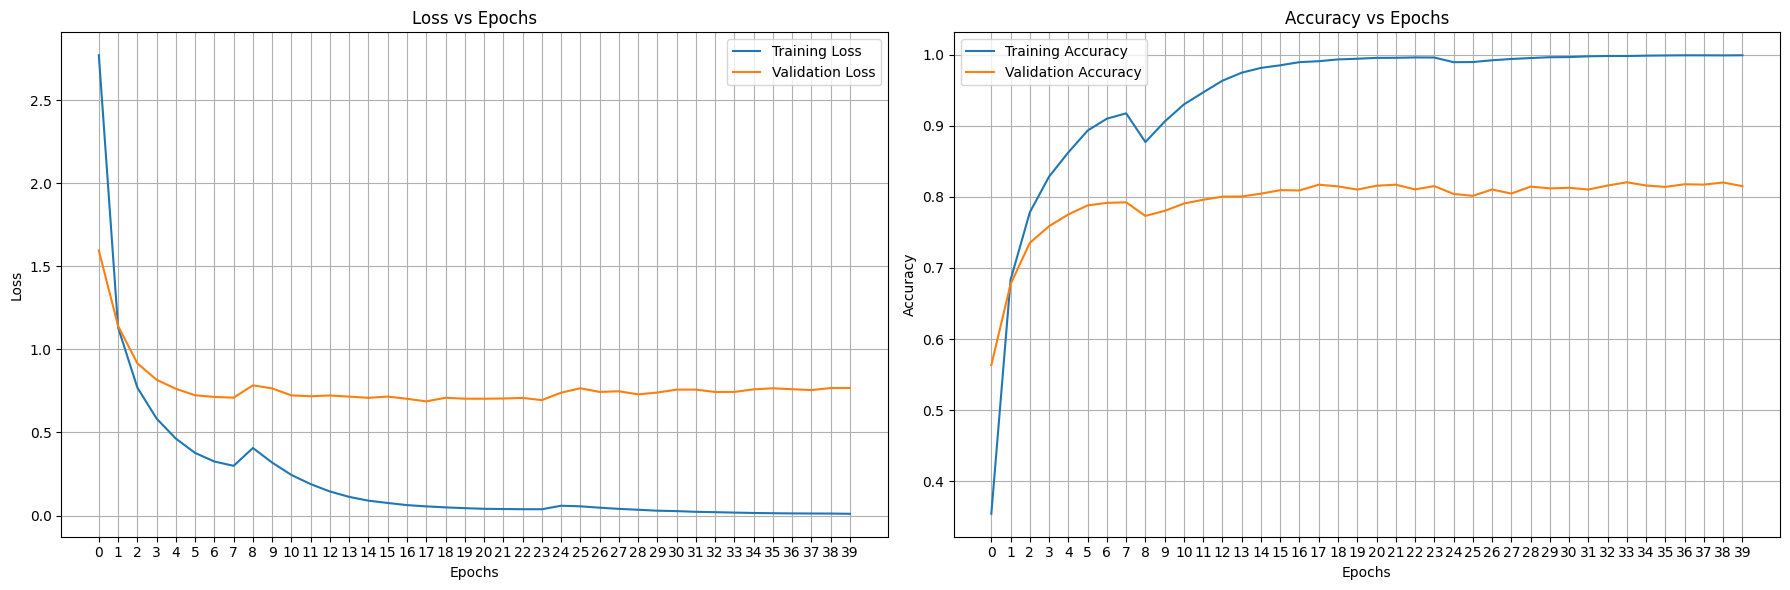

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

# Plot losses
plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.plot(all_training_losses, label='Training Loss')
plt.plot(all_validation_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()
plt.grid(True)  # Add grid
plt.xticks(range(len(all_training_losses)), rotation=0)  # Rotate ticks by 20 degrees

# Plot accuracies
plt.subplot(1, 2, 2)
plt.plot(all_training_accuracies, label='Training Accuracy')
plt.plot(all_validation_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')
plt.legend()
plt.grid(True)  # Add grid
plt.xticks(range(len(all_training_accuracies)), rotation=0)  # Rotate ticks by 20 degrees

plt.tight_layout()
plt.show()

In [13]:
# Evaluate the model on the validation dataset
test_loss, test_accuracy, _ = eval(dataloader=test_dataloader, model=model, criterion=criterion)

print(
    f"🔍 Test Results:\n"
    f"\t📉 Test Loss: {test_loss:.4f}\n"
    f"\t🎯 Test Accuracy: {100 * test_accuracy:.2f}%"
)

Eval progress:   0%|          | 0/79 [00:00<?, ?batch/s]

Eval progress: 100%|██████████| 79/79 [00:18<00:00,  4.23batch/s]

🔍 Test Results:
	📉 Test Loss: 0.7226
	🎯 Test Accuracy: 82.26%
